
Similar Dates with Jaccard Similarity >= 0.5:

MinHash LSH Results:
+----------+----------+-------------------+------------------+
|     Date1|     Date2|    JaccardDistance| JaccardSimilarity|
+----------+----------+-------------------+------------------+
|19/11/2015|24/04/2014| 0.4901960784313726|0.5098039215686274|
|21/07/2015|12/08/2015|                0.4|               0.6|
|26/03/2015|30/11/2015| 0.4821428571428571|0.5178571428571429|
|29/11/2015|10/11/2015|0.39344262295081966|0.6065573770491803|
|26/06/2014|15/05/2014| 0.4901960784313726|0.5098039215686274|
|26/06/2015|01/08/2015| 0.4871794871794872|0.5128205128205128|
|13/11/2015|08/07/2015|0.45999999999999996|              0.54|
|22/01/2015|02/05/2015|0.49056603773584906|0.5094339622641509|
|13/11/2015|29/12/2015| 0.4545454545454546|0.5454545454545454|
|05/08/2015|02/05/2015| 0.4629629629629629|0.5370370370370371|
|08/02/2014|30/03/2015|0.45999999999999996|              0.54|
|10/11/2015|21/08/2015| 0.4838709677419355|0.5161

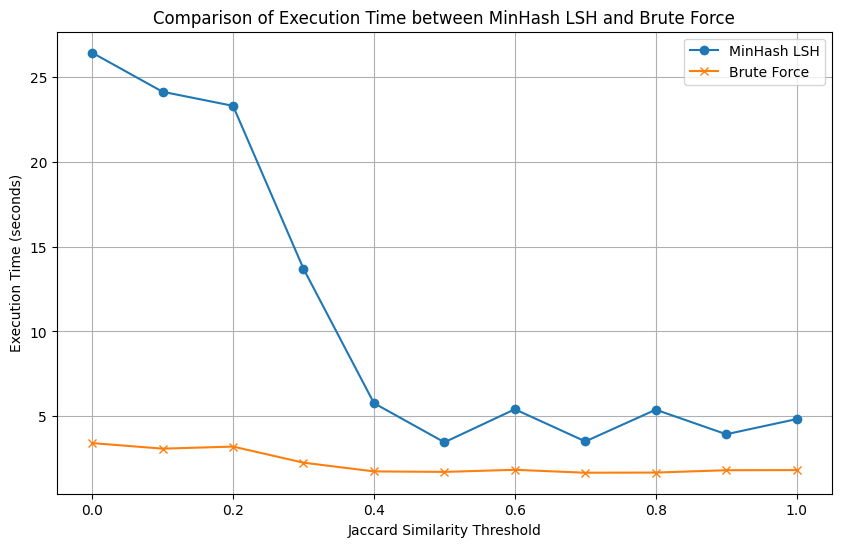

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DoubleType
from pyspark.ml.feature import CountVectorizer, MinHashLSH
import time
import matplotlib.pyplot as plt

def initialize_spark():
    """Initialize and return a SparkSession"""
    return SparkSession.builder.appName("MinHashLSH_vs_BruteForce").getOrCreate()

def prepare_data(spark, file_path="baskets.csv"):
    """
    Read and prepare the data from CSV file
    Returns: vectorized DataFrame with features
    """
    # Read CSV
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Shingling: Group by Date and collect unique items
    grouped_df = df.groupBy("Date").agg({"itemDescription": "collect_set"}) \
                  .withColumnRenamed("collect_set(itemDescription)", "items")

    # Convert to binary vectors
    cv = CountVectorizer(inputCol="items", outputCol="features", binary=True)
    cv_model = cv.fit(grouped_df)
    return cv_model.transform(grouped_df)

def find_similar_days_lsh(vectorized_df, threshold, num_hash_tables=3):
    """
    Find similar days using MinHash LSH approach
    Args:
        vectorized_df: DataFrame with features
        threshold: Jaccard similarity threshold
        num_hash_tables: Number of hash tables for LSH
    Returns: DataFrame with similar pairs
    """
    # Initialize and fit MinHash LSH model
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=num_hash_tables)
    mh_model = mh.fit(vectorized_df)

    # Calculate distance threshold from similarity threshold
    distance_threshold = 1.0 - threshold

    # Find approximate similar pairs
    result = mh_model.approxSimilarityJoin(vectorized_df, vectorized_df, distance_threshold,
                                         distCol="JaccardDistance") \
                    .select(col("datasetA.Date").alias("Date1"),
                           col("datasetB.Date").alias("Date2"),
                           col("JaccardDistance"))

    # Convert distance to similarity and filter
    result = result.withColumn("JaccardSimilarity", 1.0 - col("JaccardDistance"))
    similar_pairs = result.filter((col("JaccardSimilarity") >= threshold) &
                                (col("Date1") != col("Date2")))

    return similar_pairs

def find_similar_days_bruteforce(vectorized_df, threshold):
    """
    Find similar days using Brute Force approach
    Args:
        vectorized_df: DataFrame with features
        threshold: Jaccard similarity threshold
    Returns: DataFrame with similar pairs
    """
    # Create dictionary of date:features
    features_dict = {row['Date']: set(row['features'].indices)
                    for row in vectorized_df.collect()}

    # Calculate Jaccard similarity between two sets
    def jaccard_similarity(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return float(intersection) / union if union != 0 else 0.0

    # Compare all pairs
    results = []
    dates = list(features_dict.keys())
    for i in range(len(dates)):
        for j in range(i + 1, len(dates)):
            sim = jaccard_similarity(features_dict[dates[i]], features_dict[dates[j]])
            if sim >= threshold:
                dist = 1.0 - sim
                results.append((dates[i], dates[j], dist, sim))

    # Create DataFrame schema
    schema = StructType([
        StructField("Date1", StringType(), True),
        StructField("Date2", StringType(), True),
        StructField("JaccardDistance", DoubleType(), True),
        StructField("JaccardSimilarity", DoubleType(), True)
    ])

    return vectorized_df.sparkSession.createDataFrame(results, schema)

def compare_performance(vectorized_df, thresholds):
    """
    Compare execution times of both approaches across different thresholds
    Args:
        vectorized_df: DataFrame with features
        thresholds: List of similarity thresholds to test
    Returns: Tuple of (lsh_times, bruteforce_times)
    """
    lsh_times = []
    bruteforce_times = []

    print("\nExecution Time Comparison:")
    for threshold in thresholds:
        # LSH timing
        start_time = time.time()
        find_similar_days_lsh(vectorized_df, threshold).count()
        lsh_time = time.time() - start_time
        lsh_times.append(lsh_time)
        print(f"LSH Threshold {threshold}: {lsh_time:.4f} seconds")

        # Brute Force timing
        start_time = time.time()
        find_similar_days_bruteforce(vectorized_df, threshold).count()
        bf_time = time.time() - start_time
        bruteforce_times.append(bf_time)
        print(f"Brute Force Threshold {threshold}: {bf_time:.4f} seconds")

    return lsh_times, bruteforce_times

def plot_comparison(thresholds, lsh_times, bruteforce_times):
    """Plot the performance comparison"""
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, lsh_times, marker='o', label='MinHash LSH')
    plt.plot(thresholds, bruteforce_times, marker='x', label='Brute Force')
    plt.title("Comparison of Execution Time between MinHash LSH and Brute Force")
    plt.xlabel("Jaccard Similarity Threshold")
    plt.ylabel("Execution Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    """Main execution function"""
    # Initialize Spark and prepare data
    spark = initialize_spark()
    vectorized_df = prepare_data(spark)

    # Test with threshold 0.5
    print("\nSimilar Dates with Jaccard Similarity >= 0.5:")
    print("\nMinHash LSH Results:")
    lsh_result = find_similar_days_lsh(vectorized_df, 0.5)
    lsh_result.show()

    print("\nBrute Force Results:")
    bf_result = find_similar_days_bruteforce(vectorized_df, 0.5)
    bf_result.show()

    # Compare performance across thresholds
    thresholds = [i * 0.1 for i in range(11)]
    lsh_times, bf_times = compare_performance(vectorized_df, thresholds)

    # Plot results
    plot_comparison(thresholds, lsh_times, bf_times)

    # Clean up
    spark.stop()

if __name__ == "__main__":
    main()